In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True
});

# <center>Course 02901 - Advanced topics in machine learning</center>
## <center>Bayesian Optimization</center>
### <center>Introduction and Gaussian Processes</center>

<center>August 2020, Kristoffer H. Madsen</center>
<br>
<center>
<table style="border:none;border-collapse: collapse;border-style:hidden;background-color:#FFFFFF;border-spacing:0;margin=0;padding:0;cellspacing:0;cellpadding:0">
<tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th  style="text-align:center">Associate Professor</th><th>  </th>
<th style="text-align:center">Senior Researcher</th>
</tr>
        <tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th style="text-align:center">Section for Cognitive Systems</th><th> </th>
<th style="text-align:center">Computational Neuroimaging Group</th>
</tr>
    <tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th style="text-align:center">Department of Applied Mathematics and computer Science</th><th> </th>
<th style="text-align:center">Danish Research Centre for Magnetic Resonance</th>
</tr>
    <tr style="background-color:#FFFFFF">
<th style="text-align:center">Technical University of Denmark</th><th></th>
<th style="text-align:center">Copenhagen University Hospital Hvidovre</th>
</tr>
        <tr style="background-color:#FFFFFF">
<th style="text-align:center">khma@dtu.dk</th><th></th>
<th style="text-align:center">kristofferm@drcmr.dk</th>
</tr>
            <tr style="background-color:#FFFFFF">
<th style="text-align:center"><center><img src=imgs/dtu.png width=70></center></th><th>  </th>
<th style="text-align:center"><center><img src=imgs/drcmr.png width=210></center></th>
</tr>
</table>
    </center>

# The course topic
- Machine learning settings were active experimentation/data collection play an essential role
- I will cover two very simplistic settings
    - Bayesian Optimization (today)
    - Active Learning (tomorrow)
- In the afternoon there will be talks that relate to how the brain accomplishes some of these tasks

# Why active machine learning?
- In machine learning we typically interested in discovering statistical dependencies in a dataset to enable predictions
- In practical settings we therefore consider a dataset and fit the best possible model to that dataset
- However, in practice data availability is limited
    - Data collection is sequential and lengthy process
    - It is often expensive to get extra data
- Some data points are more informative than others
- There is often a possibility to influence the data collection process
- Intimately related to optimal experimental design (in the statistics field)
- In some cases, it is so essential that models cannot be learned without (Wednesday/Thursday/Friday)

# It is what humans do to learn
- In practice we almost always learn through an active process
- We actively plan how to probe the environment/ask questions
- We do that by having a model of how the environment will "react" to an action
- Sometimes making mistakes is actually a good way to achieve a better performance in the long run

# Example cases
- Across the course we will see examples of cases where the ability to control the data collection process is of essence
- In Bayesian optimization: we seek to find the minimum of a function
    - and we want to do something more clever than just random sampling
- In Active learning: we seek to optimally discover statistical dependencies (the shape of a function)
- Causal Inference: Causes can often not be determined from statistical dependencies alone, but require interventions (experimentation in a controlled setting)
- In reinforcement learning: sequentially identify a model to achieve a certain goal, requires that we learn both the model and the consequences of our actions

# Bayesian Optimization
- Typically used in optimization of functions when the cost function is expensive to evaluate and/or when gradients/symbolic forms of the function are unknown
- In general, the idea is to optimally plan each function evaluation such that the uncertainty of the objective (to find they minimum) is minimized in each step
- A very dominant example in the literature of this is based on Gaussian Processes (GPs)

# Bayesian optimization
## Key elements
- Model
- Data
- Objective function

# How?
## Key tools
- Uncertainty quantification
    - Most algorithm just give a point estimate
    - It will be important to quantify what we are uncertain about in order to "ask" relevant follow-up questions
- Probabilistic modeling (Bayes)
    - A way to archive the above
- Prediction of what a future experiment might bring using the current model
    - Evaluate expected knowledge (with respect to some objective) that is given by a new data point/experiment

# Motivational example
<a href="http://www.brain-fmri.com:81/BO/">http://www.brain-fmri.com/BO/</a>

# How did you do this?


## Assumptions and strategy
- Smoothness of the function - so natural for humans that I did not even have to state it
    - Had the points been random of course exercise would make little sense
- Attempt to build up an internal representation of the function (approximation of the function)
    - Probe points to determine smoothness
    - Figure out which parts of the function you are most uncertain about (based on the distance to sampled points)
    - Noise level if any (how large is variation if the same point is reevaluated)
- Natural tradeoff between exploitation (sample near where you know the value is high) and exploration (sample regions with high uncertainty)

# Machine learning to accomplish this
- In the remaining, we will focus on how to make machine do this seemingly simple task

# The multivariate Gaussian
A multivariate Gaussian has the following probability density function:
\begin{equation}
    \mathcal{N}(\mathbf{x}|\boldsymbol{\mu},\mathbf{\Sigma}) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \bigg\{ -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\top \mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\bigg\}
\end{equation} 
- A two dimensional Gaussian $\mathcal{N}\left(\boldsymbol{\mu}=\begin{bmatrix} 0\\0\end{bmatrix},\mathbf{\Sigma}=\begin{bmatrix}1&0\\0&1\end{bmatrix}\right)$

<IPython.core.display.Javascript object>


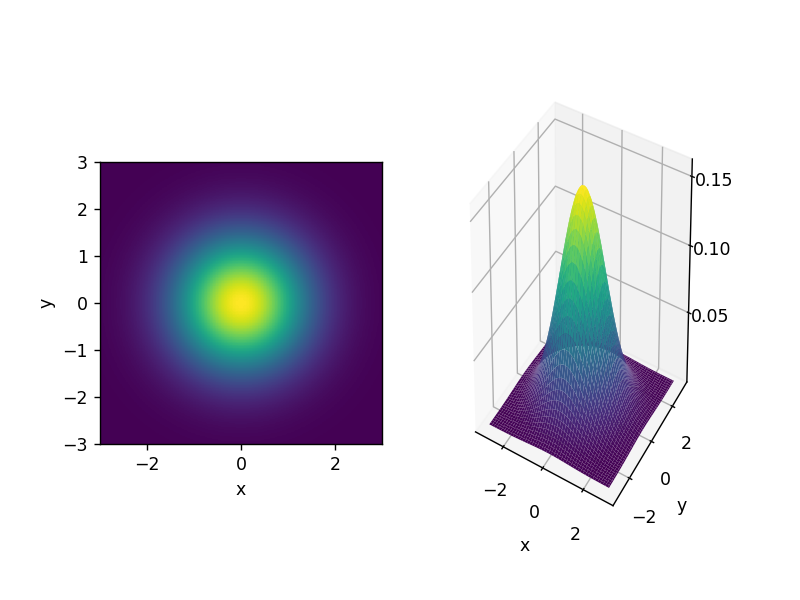

In [2]:
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider

N1 = stats.multivariate_normal(0,1)
plt.figure('Independently Gaussian distributed variables');
x = np.array(np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100),indexing='ij'))
#plt.subplot(1,2,1)
#plt.plot(x[0][:,0],N1.pdf(x[0][:,0]))
N2 = stats.multivariate_normal((0,0),np.identity(2))
plt.subplot(1,2,1)
plt.imshow(N2.pdf(x.T).T,origin='lower',extent=[x[0][0,0],x[0][-1,0],x[1][0][0],x[1][0,-1]]);
plt.xlabel('x');
plt.ylabel('y');
ax = plt.subplot(1,2,2,projection='3d');
ax.plot_surface(x[0],x[1],N2.pdf(x.T),cmap='viridis');
plt.xlabel('x');
plt.ylabel('y');


# Introducing correlation
- $\mathcal{N}\left(\boldsymbol{\mu}=\begin{bmatrix} 0\\0\end{bmatrix},\mathbf{\Sigma}=\begin{bmatrix}1&0.9\\0.9&1\end{bmatrix}\right)$

<IPython.core.display.Javascript object>


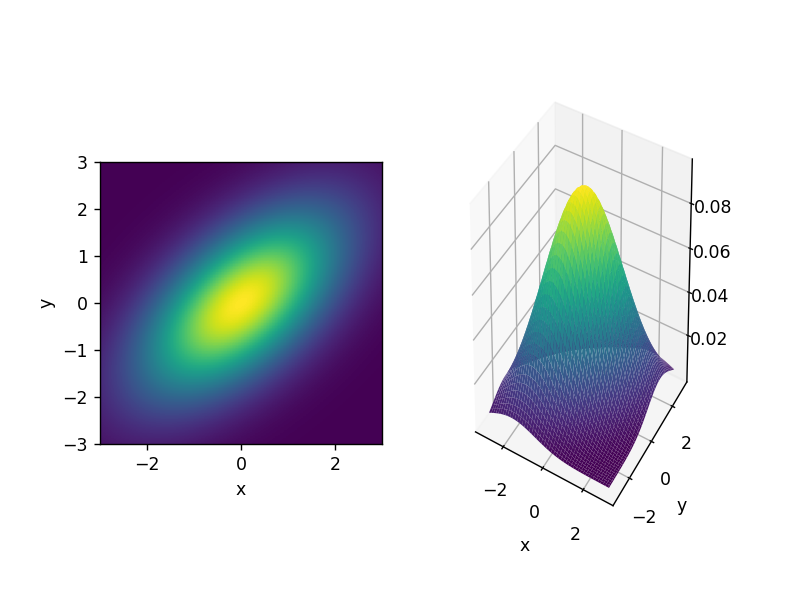

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='sigma1', max=3.0, step=0.01…

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='sigma2', max=3.0, step=0.01…

interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='sigma12', max=3.0, min=-3.0…

In [11]:
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
global C
x = np.array(np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100),indexing='ij'))
C = np.array([[1,.9],[0.9,1]])
N2 = stats.multivariate_normal((0,0),C)
plt.figure('Correlated Gaussian Variables');
plt.subplot(1,2,1);
plt.imshow(N2.pdf(x.T),origin='lower',extent=[x[0][0,0],x[0][-1,0],x[1][0][0],x[1][0,-1]]);
plt.xlabel('x');
plt.ylabel('y');
ax=plt.subplot(1,2,2,projection='3d');
ax.plot_surface(x[0],x[1],N2.pdf(x.T),cmap='viridis');
plt.xlabel('x');
plt.ylabel('y');
eps=0.01
def redraw():
    global C
    plt.clf()
    N2 = stats.multivariate_normal((0,0),C)
    plt.figure('Correlated Gaussian Variables');
    plt.subplot(1,2,1);
    plt.imshow(N2.pdf(x.T),origin='lower',extent=[x[0][0,0],x[0][-1,0],x[1][0][0],x[1][0,-1]]);
    plt.xlabel('x');
    plt.ylabel('y');
    ax=plt.subplot(1,2,2,projection='3d');
    ax.plot_surface(x[0],x[1],N2.pdf(x.T).T,cmap='viridis');
    plt.xlabel('x');
    plt.ylabel('y');
    plt.draw()

def update1(sigma1):
    global C
    if (sigma1*C[1,1])<=(C[0,1]**2+eps):
        sigma1=C[0,1]**2/C[1,1]+eps
        widg1.children[0].value=sigma1
    else:
        C[0,0]=sigma1
        redraw()
def update2(sigma2):
    global C
    if (sigma2*C[0,0])<=(C[0,1]**2+eps):
        sigma2=C[0,1]**2/C[0,0]+eps
        widg2.children[0].value=sigma2
    else:
        C[1,1]=sigma2
        redraw()
def update3(sigma12):
    global C
    if np.prod(np.diag(C))<=(sigma12**2+eps):
        sigma12=np.sign(sigma12)*np.sqrt(np.prod(np.diag(C)))-eps
        widg3.children[0].value=sigma12
    else:
        C[0,1]=C[1,0] = sigma12
        redraw()

slider1=FloatSlider(value=1.,min=0.0, max=3., step=.01,continuous_update=False)
slider2=FloatSlider(value=1.,min=0.0, max=3., step=.01,continuous_update=False)
slider3=FloatSlider(value=0.9,min=-3.0, max=3., step=.01,continuous_update=False)

widg1=interactive(update1,sigma1=slider1)
widg2=interactive(update2,sigma2=slider2)
widg3=interactive(update3,sigma12=slider3)

display(widg1)
display(widg2)
display(widg3)


# Marginal distributions
Are also Gaussian, and can be obtained by integrating over the other variable:
\begin{align}
\begin{split}
p(x_1) &= \int {x_2} p(x_1, x_2| \boldsymbol{\mu}, \mathbf{\Sigma}) d{x}_2
%\\
%p(x_2) &= \int {x_1} p(x_1, x_2| \boldsymbol{\mu}, \mathbf{\Sigma}) d{x}_1   
\end{split}
\end{align}

Below 1000 samples from the 2D Gaussian distribution, with KDE and marginal distributions

<IPython.core.display.Javascript object>


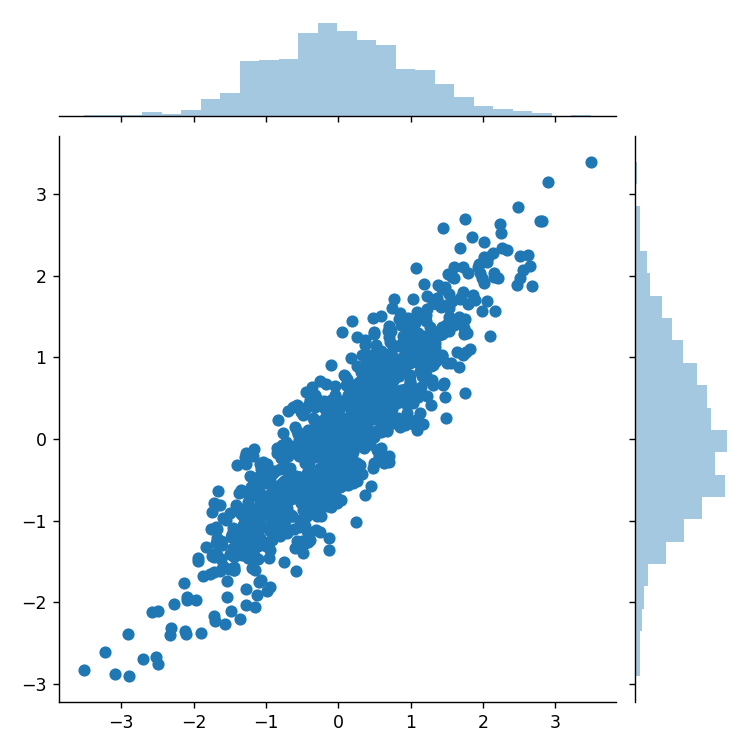

<IPython.core.display.Javascript object>


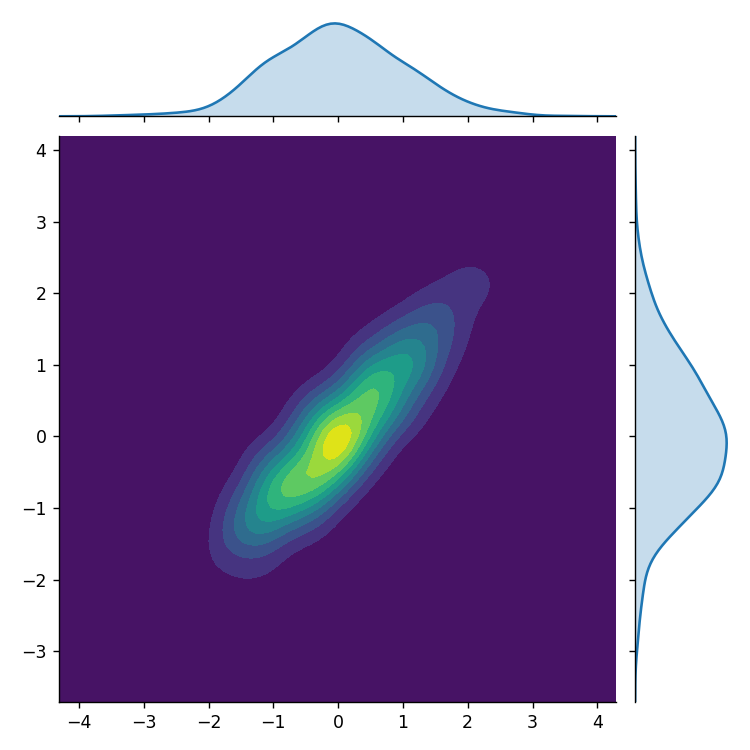

In [12]:
x, y = np.random.multivariate_normal([0,0], [[1,.9],[.9,1]], 1000).T
sns.jointplot(x=x,y=y,kind='scatter',cmap='viridis');
sns.jointplot(x=x,y=y,kind='kde',cmap='viridis');

# Tips on how to show that the marginal distribution is Gaussian
1. Write in terms of the block matrix inversion lemma (the precision matrix) see https://en.wikipedia.org/wiki/Block_matrix
2. Separate terms that contain $\mathbf{x}_b$
3. Write as square form (matrix completion of squares)
4. Recognize that the part that depends on $\mathbf{x}_b$ is a Gaussian
5. Use the fact that the integral across a distribution is one (add in the inverse normalization constant)
6. Recognize that the remaining terms form a Gaussian, and match the terms from the block matrix inversion lemma

$\begin{bmatrix}
    \mathbf{A} & \mathbf{B} \\
    \mathbf{C} & \mathbf{D}
  \end{bmatrix}^{-1} = \begin{bmatrix}
     \left(\mathbf{A} - \mathbf{BD}^{-1}\mathbf{C}\right)^{-1} &
      -\left(\mathbf{A}-\mathbf{BD}^{-1}\mathbf{C}\right)^{-1}\mathbf{BD}^{-1} \\
    -\mathbf{D}^{-1}\mathbf{C}\left(\mathbf{A} - \mathbf{BD}^{-1}\mathbf{C}\right)^{-1} &
       \quad \mathbf{D}^{-1} + \mathbf{D}^{-1}\mathbf{C}\left(\mathbf{A} - \mathbf{BD}^{-1}\mathbf{C}\right)^{-1}\mathbf{BD}^{-1}
  \end{bmatrix}.
$

# Conditional distributions
- Assume that we already know $\mathbf{x}_b$ this means that the "possible" values of $\mathbf{x}_a$ will be restricted
![Image not found!](imgs/conditional.png)
Again, rather amazingly actually, the conditional distribution is Gaussian

\begin{align}
\begin{split}
p(\mathbf{x}_a|\mathbf{x}_b) = \frac{p(\mathbf{x}_a, \mathbf{x}_b|\boldsymbol{\mu}, \mathbf{\Sigma})}{\int_{\mathbf{x}_a}p(\mathbf{x}_a, \mathbf{x}_b| \boldsymbol{\mu}, \mathbf{\Sigma}) d\mathbf{x}_a} = \frac{p(\mathbf{x}_a, \mathbf{x}_b|\boldsymbol{\mu}, \mathbf{\Sigma})}{p(\mathbf{x}_b)} 
\end{split}
\end{align}
$$p(\mathbf{x}_a|\mathbf{x}_b) = \mathcal{N}(\mathbf{x}| \boldsymbol{\mu}_{a|b}, \mathbf{\Sigma}_{a|b})$$
where
\begin{align}
\label{eqn:conditional1}
\begin{split}
\boldsymbol{\mu}_{a|b} &= \boldsymbol{\mu}_{a} + \mathbf{\Sigma}_{ab}\mathbf{\Sigma}_{bb}^{-1}(\mathbf{x}_b - \boldsymbol{\mu}_{b})
\end{split}
\end{align}

# Tips on how to show that the conditional distribution is Gaussian
1. Write in terms of the block matrix inversion lemma (the precision matrix) see https://en.wikipedia.org/wiki/Block_matrix
2. Separate terms that contain $\mathbf{x}_a$, note that the integral does not depend on $\mathbf{x}_a$
3. Write as square form (matrix completion of squares)
4. Recognize that the expression is a Gaussian, and match the terms from the block matrix inversion lemma


$\begin{bmatrix}
    \mathbf{A} & \mathbf{B} \\
    \mathbf{C} & \mathbf{D}
  \end{bmatrix}^{-1} = \begin{bmatrix}
     \left(\mathbf{A} - \mathbf{BD}^{-1}\mathbf{C}\right)^{-1} &
      -\left(\mathbf{A}-\mathbf{BD}^{-1}\mathbf{C}\right)^{-1}\mathbf{BD}^{-1} \\
    -\mathbf{D}^{-1}\mathbf{C}\left(\mathbf{A} - \mathbf{BD}^{-1}\mathbf{C}\right)^{-1} &
       \quad \mathbf{D}^{-1} + \mathbf{D}^{-1}\mathbf{C}\left(\mathbf{A} - \mathbf{BD}^{-1}\mathbf{C}\right)^{-1}\mathbf{BD}^{-1}
  \end{bmatrix}.
$

# Geometric illustration
- It is extremely difficult to visualize anything beyond a 2D Gaussian

<IPython.core.display.Javascript object>


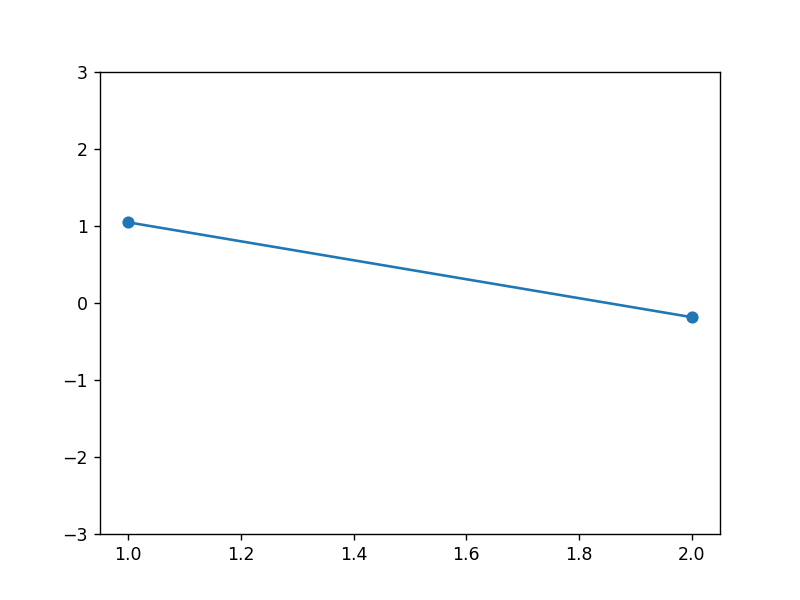

In [13]:
%matplotlib notebook
x = np.arange(2)+1
fig = plt.figure('Geometric illustration of two points');
y = [0,np.random.randn(1)[0]]
plt.plot(x,y,'-o');
plt.ylim(-3,3)
def onclick(event):
    y = [event.ydata, event.ydata + np.random.randn(1)]
    plt.clf();
    plt.plot(x,y,'-o');
    plt.ylim(-3,3);
    plt.draw();
fig.canvas.mpl_connect('button_press_event',onclick);

<IPython.core.display.Javascript object>


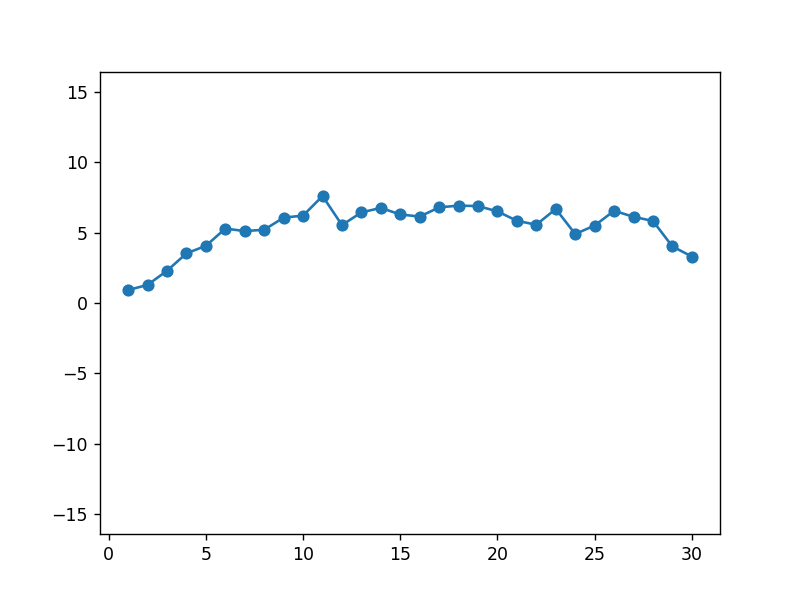

In [14]:
%matplotlib notebook
n = 30
r = np.sqrt(n)*3
x = np.arange(n)+1
fig = plt.figure('Many correlated dimensions');
y = np.zeros(len(x))
y[0] = 0
for i in range(1,len(x)):
    y[i] = y[i-1]+np.random.randn(1)
plt.plot(x,y,'-o');
plt.ylim(-r,r)
def onclick(event):
    y[0] = event.ydata
    for i in range(1,len(x)):
        y[i] = y[i-1]+np.random.randn(1)
    plt.clf();
    plt.plot(x,y,'-o');
    plt.ylim(-r,r);
    plt.draw();
fig.canvas.mpl_connect('button_press_event',onclick);

# Regression
$$y = \mathbf{w}^T\mathbf{x} + \epsilon$$
- The posterior probability (marginalizing over all possible $\mathbf{w}$'s given some distribution)
\begin{align}
    \begin{split}
        p(\mathbf{w}|D) &= \frac{p(D|\mathbf{w}) p(\mathbf{w})}{p(D)} \\
        &\propto p(D|\mathbf{w}) p(\mathbf{w})
    \end{split}
\end{align}
If we assume that both $p(D|\mathbf{x})$ and $p(\mathbf{w})$ are Gaussian we already know that the posterior will be Gaussian


# Regression
- Say that we observed some points $\mathbf{y_*}= f(\mathbf{X_*})$ then we can condition on these known points
$$p(y_*|D,\mathbf{x_*}) = p(\mathbf{y_*}|\mathbf{y}, \mathbf{X}, \mathbf{X_*}) = \mathcal{N}(\boldsymbol{\mu}_{y_*|\mathbf{y}}, \mathbf{\Sigma}_{y_*|\mathbf{y}})$$
- We can then follow the recipe for getting this distribution that we "derived" above
- We just have to determine/decide what the $\mathbf{\Sigma}_{y_*|\mathbf{y}}$ (and $\boldsymbol{\mu}_{y_*|\mathbf{y}}$ if we do not standardize data) is
- This is where the so-called kernels/covariance functions come in


# Kernels
- Have to be positive definte (like variances have to be positive)
- Should reflect our belief about the data typically this means that points that are close are highly correlated
- Measures distance/similarity between the $\mathbf{x}$'s
- How are the data points (observed or unobserved) correlated with one another
- Squared exponential kernel:
\begin{align}
    k_{\text{SE}}(x_i, x_j) = \sigma^2 \exp\left({-\frac{\left\|x_i-x_j\right\|^2}{2l^2}}\right)
\end{align}
- There are wide range of established kernels available the including for example the periodic and Matérn class kernels
- Different types of kernels can be scaled and added (and they will still be valid kernels)

# Kernel for noisy observations
- If a training point is reacquired we still expect variance (think of this like the distance is not really zero)
- In essence simply just add something to the diagonal of the kernel matrix
$$\mathbf{K}=\mathbf{K}_\text{SE}+\sigma^2_n \mathbf{I} $$

<IPython.core.display.Javascript object>


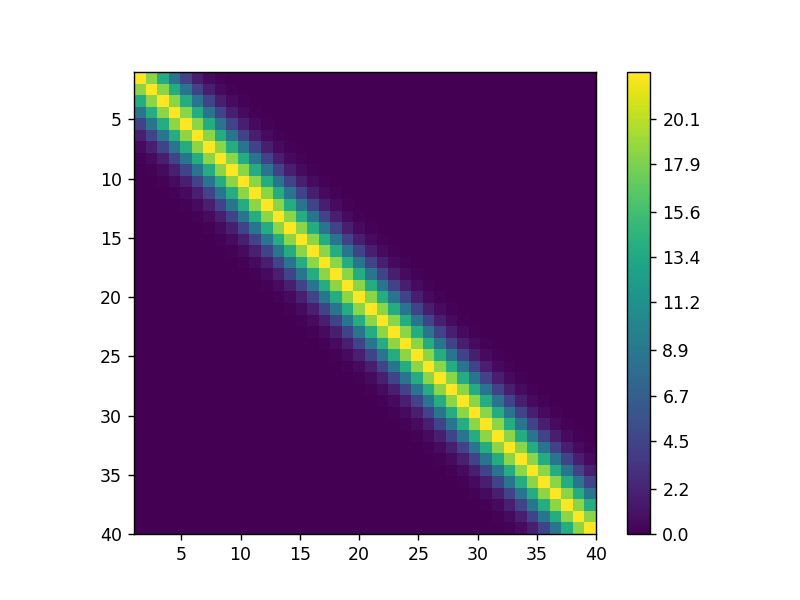

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0), FloatSlider(value=1.0, descriptio…

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
def kernel_se(x,sigma=1,l=1,sigma_n=0):
    return sigma**2 * np.exp(-0.5*(x[None]-x[:,None])**2/(l**2)) + sigma_n * np.identity(x.shape[0])
x=np.arange(40)+1
K=kernel_se(x)
plt.figure('Squared exponential Kernel');
im=plt.imshow(K,cmap='viridis',origin='upper',extent=[x[0],x[-1],x[-1],x[0]]);
cbar=plt.colorbar()
@interact(sigma=(0,10.0), l=(0,10.0), sigma_n=(0,10.0))
def update(sigma=1,l=1,sigma_n=0):
    K=kernel_se(x,sigma,l,sigma_n)
    im.set_data(K);    
    new_cbar_ticks = np.round(np.linspace(0, K.max(), num=11, endpoint=True)*10)/10
    cbar.set_ticks(new_cbar_ticks)
    cbar.set_ticklabels(new_cbar_ticks)
    cbar.mappable.set_clim(0, K.max())
    fig.canvas.draw_idle();

# Putting everything together
\begin{align}
\begin{split}
    p(\mathbf{y_*}|\mathbf{y}, \mathbf{X}, \mathbf{X_*}) &= \mathcal{N}(\boldsymbol{\mu}_{\mathbf{y_*}|\mathbf{y}}, \mathbf{\Sigma}_{\mathbf{y_*}|\mathbf{y}})\\
    \boldsymbol\mu_{\mathbf{y_*}|\mathbf{y}} &= K(\mathbf{X_*}, \mathbf{X}) [K(\mathbf{X},\mathbf{X})+ \sigma_n^2 \mathbf{I}]^{-1}\mathbf{y}\\
    \mathbf{\Sigma}_{\mathbf{y_*}|\mathbf{y}} &= K(\mathbf{X_*}, \mathbf{X_*}) - K(\mathbf{X_*},\mathbf{X})[K(\mathbf{X},\mathbf{X})+ \sigma_n^2 \mathbf{I}]^{-1}K(\mathbf{X}, \mathbf{X_*})
\end{split}
\end{align}

# Or more compact
With: $\mathbf{K} = K(\mathbf{X},\mathbf{X})$, $\mathbf{K_*} = K(\mathbf{X},\mathbf{X_*})$ and $\mathbf{K_{**}}=K(\mathbf{X_*}, \mathbf{X_*})$

\begin{align}
\begin{split}
    p(\mathbf{y_*}|\mathbf{y}, \mathbf{X}, \mathbf{X_*}) &= \mathcal{N}(\boldsymbol\mu_{\mathbf{y_*}|\mathbf{y}}, \mathbf{\Sigma}_{\mathbf{y_*}|\mathbf{y}})\\
    \boldsymbol\mu_{\mathbf{y_*}|\mathbf{y}} &= \mathbf{K_*}^T [\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1}\mathbf{y}\\
    \mathbf{\Sigma}_{\mathbf{y_*}|\mathbf{y}} &= \mathbf{K_{**}} - \mathbf{K_*}^T[\mathbf{K}+ \sigma_n^2 \mathbf{I}]^{-1}\mathbf{K_*}
\end{split}
\end{align}

Note that this defines the full Gaussian posterior distribution of the test data, given the observations 

# Kernel hyperparameters
- How do we select them?
    - Choose the ones that fit the training data best
    - We already have a way to measure this
    - Maximize training likelihood
$$\mathcal{N}(\mathbf{y}|\mathbf{0}, \mathbf{K}+\sigma_n^2 \mathbf{I})$$
\begin{align}
\begin{split}
\log p(\mathbf{y}|\mathbf{X}) = \log \mathcal{N}(\mathbf{y}|\mathbf{0}, \mathbf{K}+\sigma_n^2 \mathbf{I}) = - \frac{1}{2}\mathbf{y}[\mathbf{K}+\sigma_n^2 \mathbf{I}]^{-1}\mathbf{y} -\frac{1}{2}|\mathbf{K}+\sigma_n^2 \mathbf{I}|-\frac{N}{2}\log(2\pi)
\end{split}
\end{align}
- Simply figure out what to plug into the expression to make this maximal
- Unfortunately no closed form solution

# Gaussian Process Regression
- A prior over all functions (typically implementing a smoothness assumptions)
    - No choice of basis function (we actually integrate them out)
- Non-parametric
    - Complexity can grow with number of data points
- Prior information is given by the Gaussian assumption and the kernel function
- Provides access to an analytical form of the posterior probability
    - No sampling required
    - Uncertainty quantification
- Complexity grows like $\mathcal{O}(N^3)$ with the number of data points
    - Inverting the covariance matrix
    - Tricks to speed this up but a rather complicated topic

# Gaussian Process Regression
- Non-parametric regression procedure
- Assumes a regression model but integrates out basis functions/regression weights, via Gaussian prior
- Only relies on definition of covariance function (kernel), typically implements smoothness assumption
- Provides an estimation of the full predictive distribution
- Important if we want to quantify uncertainty

# Kernels and kernel parameters
- Squared exponential covariance function is a special case of the Matérn covariance function (for $\nu\to\inf$)
$$k_{\text{SE}}(x_i, x_j) = \sigma^2 \exp\left({-\frac{d^2}{2\rho^2}}\right)\quad d=\left\|x_i-x_j\right\|$$
- Matérn 5/2 (in practice this is default in many uses of GPs)
$$C_{5/2}(d) = \sigma^2\left(1+\frac{\sqrt{5}d}{\rho}+\frac{5d^2}{3\rho^2}\right)\exp\left(-\frac{\sqrt{5}d}{\rho}\right)$$
- By optimizing training likelihood we can determine the most appropriate kernel parameters
$$\log p(\mathbf{y}|\mathbf{X}) = \log \mathcal{N}(\mathbf{y}|\mathbf{0}, \mathbf{K}+\sigma_n^2 \mathbf{I}) = - \frac{1}{2}\mathbf{y}[\mathbf{K}+\sigma_n^2 \mathbf{I}]^{-1}\mathbf{y} -\frac{1}{2}|\mathbf{K}+\sigma_n^2 \mathbf{I}|-\frac{N}{2}\log(2\pi)$$
- The optimization scheme would typically be a quasi Newton procedure, often BFGS

# Kernel hyperpriors
- Optimization can be somewhat unstable, so considering a prior over some parameters might be helpful
- In practice works by just multiplying the defined prior onto the expression above
- In lecture notes this is done for the noise covariance (to restrict this to some small value)
There is also a possibility to integrate out kernel parameters under a distribution
- Sampling procedure or other approximation needed
- Can provide better stability
- Supported in some packages such as GPy

# GP demo
- Press key 'o' to optimize kernel parameters according to training likelihood
- Press key 'c' to sample 5 lines from the posterior density

<IPython.core.display.Javascript object>


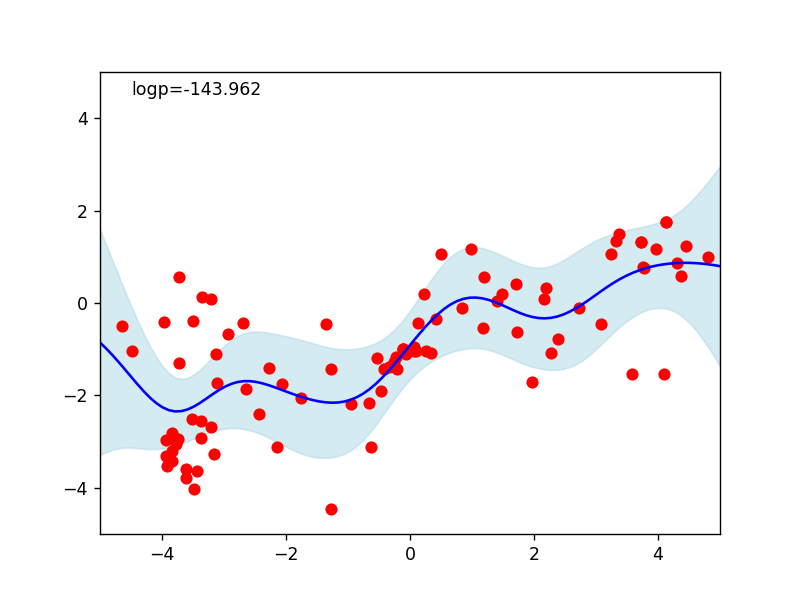

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='sigma', max=10.0, min=0.001…

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='l', max=10.0, min=0.001, st…

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma_n', max=10.0, min=0.0…

interactive(children=(Dropdown(description='Kernel', options=(('squared exponential', <function squared_expone…

interactive(children=(Checkbox(value=False, description='Auto optimize kernel parameters'), Output()), _dom_cl…

In [16]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure('GP regression');
ax = fig.add_subplot(111);
global step
step = 0
import torch as t
from ipywidgets import interact
import scipy.optimize

## kernel definition
def squared_exponential_kernel(a, b, lengthscale, variance):
    """ GP squared exponential kernel """
    # compute the pairwise distance between all the point
    # sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqdist = (a**2).sum(1)[:,None] + (b**2).sum(1) - 2 * a@b.transpose(1,0)
    return variance * np.e**(-.5 * (1/lengthscale**2) * sqdist)
    # return variance * np.exp(-.5 * (1/lengthscale**2) * sqdist)

def matern52(a, b, lengthscale, variance):
    #C_{5/2}(d) = \sigma^2\left(1+\frac{\sqrt{5}d}{\rho}+\frac{5d^2}{3\rho^2}\right)\exp\left(-\frac{\sqrt{5}d}{\rho}\right)
    # compute the pairwise distance between all the point
    # d2 = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    d2 = (a**2).sum(1)[:,None] + (b**2).sum(1) - 2 * a@b.transpose(1,0)
    return variance * (1 + np.sqrt(5.)*d2**(0.5)/lengthscale + 5*d2/(3 * lengthscale**2)) * np.e**(-np.sqrt(5.)*d2**0.5/lengthscale)

kernel = matern52
autoopt = False

def fit_GP(X, y, Xtest, kernel, lengthscale, kernel_variance, noise_variance, period=1):
    ## we should standardize the data
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    K = kernel(X, X, lengthscale, kernel_variance)
    L = np.linalg.cholesky(K + noise_variance * np.eye(len(X)))

    # compute the mean at our test points.
    Ks = kernel(X, Xtest, lengthscale, kernel_variance)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  #
    mu = Ks.T @ alpha

    v = np.linalg.solve(L, Ks)
    # compute the variance at our test points.
    Kss = kernel(Xtest, Xtest, lengthscale, kernel_variance)
    # s2 = np.diag(K_) - np.sum(Lk ** 2, axis=0)
    covariance = Kss - (v.T @ v)
    # s = np.sqrt(s2)
    return mu, covariance

def loglike(X,y,kernel,lengthscale, kernel_variance, noise_variance):
    #this is not a recommended way of calculating the likelihood from an efficiency point of view
    X = t.from_numpy(np.array(X).reshape(-1, 1))
    y = t.from_numpy(np.array(y).reshape(-1, 1))
    K = kernel(X, X, lengthscale, kernel_variance) + noise_variance * t.eye(len(X),dtype=t.float64)
    return -.5 * y.transpose(1,0)@t.inverse(K)@y - 0.5*t.logdet(K)- .5 * len(X) * np.log(2*np.pi)
    #the below would be better from a stability point of view
    #but the autograd for cholesky seems to be broken at least in pytorch 1.6 
    #L = t.cholesky(K)
    #alpha = t.cholesky_solve(t.cholesky_solve(y,L),L.transpose(1,0))
    #return -.5 * y.transpose(1,0)@alpha - .5 * t.sum(t.diag(L)) - .5 * len(X) * np.log(2*np.pi)

global lengthscale, kernel_variance, noise_var
## parameters definition
lengthscale = 1 # determines the lengths of the wiggle
kernel_variance = 1 # scale factor
noise_var = .2
n_test_point = 100
n_samples = 10
Xtrain = []
ytrain = []
Xtest = np.linspace(-5, 5, n_test_point).reshape(-1,1)

def on_sample(event):
    if event.key=='c':
        global step, lengthscale, kernel_variance, noise_var
        ## we want the mean + the std deviation but also some samples from the posterior
        # clear frame
        plt.clf()
        # we have to refit the GP
        mu, covariance = fit_GP(Xtrain, ytrain, Xtest, kernel, lengthscale, kernel_variance, noise_var)
        # we should get the var
        var = np.sqrt(np.diag(covariance))
        # and we have to sample for it
        samples = np.random.multivariate_normal(mu.reshape(-1), covariance, n_samples)  # SxM
        plt.plot(Xtrain, ytrain, 'ro')
        plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var, color='lightblue', alpha=0.5)
        plt.plot(Xtest, mu, 'red')
        for sample_id in range(n_samples):
            plt.plot(Xtest, samples[sample_id])
        plt.axis([-5, 5, -5, 5])
        plt.draw()  # redraw
    elif event.key=='x':
        optim_hp2()
    elif event.key=='v':
        optim_hp3()
    elif event.key=='o':
        optim_hp()

def on_click1(event):
    global lengthscale, kernel_variance, noise_var, autoopt
    if not event.xdata is None and not event.ydata is None:
        global step
        Xtrain.append(event.xdata)
        ytrain.append(event.ydata)
        if autoopt:
            optim_hp()
        step += 1
        # we have to refit the GP
        redraw()

def redraw():
    global lengthscale, kernel_variance, noise_var
    mu, covariance = fit_GP(Xtrain, ytrain, Xtest, kernel, lengthscale, kernel_variance, noise_var)
    var = np.sqrt(np.diag(covariance))
    plt.clf()
    plt.plot(Xtrain, ytrain, 'ro')
    plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var,  color='lightblue', alpha=0.5)
    plt.plot(Xtest, mu, 'blue')
    plt.axis([-5, 5, -5, 5])
    if len(Xtrain)>0:
        plt.text(-4.5,4.5,'logp=%.3f'%loglike(Xtrain,ytrain,kernel,lengthscale, kernel_variance, noise_var))
    plt.draw() #redraw

def optim_hp():
    global lengthscale, kernel_variance, noise_var
    kpar = [t.autograd.Variable(t.tensor(i,dtype=t.float64),requires_grad=True) for i in (lengthscale, kernel_variance, noise_var)]
    opt = t.optim.LBFGS(kpar,lr=0.1,line_search_fn='strong_wolfe')
    
    def closure():
        loss = -loglike(Xtrain,ytrain,kernel,t.abs(kpar[0]),t.abs(kpar[1]),t.abs(kpar[2]))
        opt.zero_grad()
        loss.backward()
        return loss
    for i in range(10):
        opt.step(closure)
    lengthscale = np.abs(kpar[0].item())
    kernel_variance = np.abs(kpar[1].item())
    noise_var = np.abs(kpar[2].item())+np.spacing(1)
    #print(loglike(Xtrain,ytrain,kernel,lengthscale, kernel_variance, noise_var))
    #print((lengthscale, kernel_variance, noise_var))
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var

def ll2(x):
    kpar = [t.autograd.Variable(t.tensor(i,dtype=t.float64),requires_grad=True) for i in x]
    loss = -loglike(Xtrain,ytrain,kernel,t.abs(kpar[0]),t.abs(kpar[1]),t.abs(kpar[2]))
    loss.backward()
    g=np.zeros(len(kpar))
    for i,k in enumerate(kpar):
        g[i] = k.grad.item()
    return (loss.item(),g)

def optim_hp2():
    global lengthscale, kernel_variance, noise_var
    ll=lambda kpar: -loglike(Xtrain,ytrain,kernel,np.abs(kpar[0]),np.abs(kpar[1]),np.abs(kpar[2]))[0][0]
    print(np.array((lengthscale, kernel_variance, noise_var)))
    res=scipy.optimize.minimize(ll2,np.array((lengthscale, kernel_variance, noise_var)),jac=True)
    kpar=res.x
    print(res.x)
    lengthscale = np.abs(kpar[0])
    kernel_variance = np.abs(kpar[1])
    noise_var = np.abs(kpar[2])+np.spacing(1)
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var
    
def optim_hp3():
    global lengthscale, kernel_variance, noise_var
    ll=lambda kpar: -loglike(Xtrain,ytrain,kernel,np.abs(kpar[0]),np.abs(kpar[1]),np.abs(kpar[2]))[0][0]
    res=scipy.optimize.minimize(ll,np.array((lengthscale, kernel_variance, noise_var)))
    kpar=res.x
    lengthscale = np.abs(kpar[0])
    kernel_variance = np.abs(kpar[1])
    noise_var = np.abs(kpar[2])+np.spacing(1)
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var
    
mu, covariance = fit_GP(Xtrain, ytrain, Xtest, kernel, lengthscale, kernel_variance, noise_var)
var = np.sqrt(np.diag(covariance))

plt.plot(Xtrain, ytrain, 'ro');
plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var,  color='lightblue', alpha=0.5);
plt.plot(Xtest, mu, 'blue')
plt.axis([-5, 5, -5, 5])
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
from ipywidgets import Dropdown
from ipywidgets import Checkbox
from IPython.display import display
sliders=[FloatSlider(value=1.,min=0.001, max=10., step=.01,continuous_update=False) for i in range(3)]
sliders[2].value=0.1
kernsel=Dropdown(options=[('squared exponential',squared_exponential_kernel),('matern 5/2',matern52)],value=squared_exponential_kernel)
auto_opt_sel=Checkbox(value=False,description='Auto optimize kernel parameters')

def update1(sigma):
    global lengthscale, kernel_variance, noise_var
    kernel_variance=sigma
    redraw()
    
def update2(l):
    global lengthscale, kernel_variance, noise_var
    lengthscale=l
    redraw()
    
def update3(sigma_n):
    global lengthscale, kernel_variance, noise_var
    noise_var=sigma_n
    redraw()
def update4(Kernel):
    global kernel
    kernel = Kernel
    if autoopt:
        optim_hp()
    redraw()
def update5(auto_opt):
    global autoopt
    autoopt = auto_opt
    if autoopt:
        optim_hp()
    redraw()
    
widg1=interactive(update1,sigma=sliders[0])
widg2=interactive(update2,l=sliders[1])
widg3=interactive(update3,sigma_n=sliders[2])
widg4=interactive(update4,Kernel=kernsel)
widg5=interactive(update5,auto_opt=auto_opt_sel)

fig.canvas.mpl_connect('button_press_event',on_click1)
fig.canvas.mpl_connect('key_press_event',on_sample)
display(widg1);
display(widg2);
display(widg3);
display(widg4);
display(widg5);

# Objectives in Bayesian optimization
- Find the <b>global</b> optimum (global optimization procedure)
- Optimization of non-convex and stochastic functions
- Used when the cost function is expensive to evaluate
- Balance between exploitation and exploration

# An illustrative example
## www.brain-fmri.com/BO/
- The idea is that you get a function value at 9 grid points across an image
- The objective is to find the largest function value
- You have 7 additional guesses, you can click on the image to put the position in the X and Y fields
- Click submit to evaluate the point
- It runs rather slowly (just running on a slow server at home)
- It will be a different underlying function each time

# Bayesian optimization procedure
- Acquire initial points
- For each iteration
    - Fit function with uncertainty quantification in practice often a GP
    - Optimize kernel parameters
    - Calculate acquisition function across feasible input space
    - Select best point
    - Evaluate function at this point

# Acquisition functions 
- A function that we can evaluate (quicker that the objective function itself) to determine the "value" of evaluating that point
- Should take into account the uncertainty of the function
- Typically has a free parameter that trades of exploitation/exploration

# Probability of improvement
- The probability that the objective is above the current best value
$$\text{PI}(\mathbf{x}) = \text{P}(f(\mathbf{x}) \geq f(\mathbf{x}^+))$$
- Using properties of the Gaussian distribution this is easy, but requires evaluation of the cumulative distribution function
    - This so-called error function has no easy analytical form but is provided in almost any software package
    $$\Phi(z) := \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{z} e^{-\frac{1}{2}u^2} du$$
- So if we standardize the estimated objective we have
$$\begin{align}
\label{eq:our_PI}
\begin{split}
\text{PI}(\mathbf{x}) &= \text{P}(f(\mathbf{x}) \geq f(\mathbf{x}^+) + \xi) = \\
               &= \Phi\biggl(\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})}\biggr)
\end{split}
\end{align}$$


<img src="imgs/PI.png">

# Expected improvement
- Instead of working with the probability this functions tries to quantify the expected improvement
- Here we denote the improvement $\text{I}(\mathbf{x})$:
$$\text{I}(\mathbf{x}) = \max \{0, f_{t+1}(\mathbf{x}) - f(\mathbf{x}^+)\}$$
- And take the expected value of this improvement
    - Scale a $\mathcal N(0,1)$ variable with the variance and add the mean function, then manipulate the expression to get the expectation
\begin{align}
\begin{split}
\text{EI}(\mathbf{x}) = \left\{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
(\mu(\mathbf{x}) - f(\mathbf{x}^+)) \Phi(Z) + \sigma(\mathbf{x})  \phi(Z) \hspace{1.66cm} & \text{if } \sigma(\mathbf{x}) > 0\\ 
0  \hspace{6.5cm} & \text{if } \sigma(\mathbf{x}) \leq 0
\end{array}
\right.
\end{split}
\end{align}
where $$Z = \frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi }{\sigma(\mathbf{x})}$$
and $\xi$ is a parameter to control the exploitation/exploration tradeoff. $\phi$ is the Normal density function.

# Upper confidence bound
- Directly use the maximum value that we might expect
- Original formulation just use the mean and add "some" standard deviations to it
\begin{align}
\begin{split}
\text{UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \kappa \sigma (\mathbf{x})
\end{split}
\end{align}
- The expression below will ensure asymptotic zero regret - that is it should eventually converge to the correct solution. 
\begin{align}
\begin{split}
\text{GP-UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \sqrt{\nu \beta_t} \sigma (\mathbf{x})
\end{split}
\end{align}
with $\nu=1$ and $\beta_t = 2 \log(\frac{t^{\frac{d}{2}+2}\pi^2}{3 \delta})$
 where $t$ is the iteration number, $d$ is the dimensionality of the problem, and $\delta \in (0,1)$

# Different acquisition functions
<img src="imgs/Acqs1.png">

<img src="imgs/Acqs2.png">
Illustrations shamelessly stolen from: "A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning" by Eric Brochu, Vlad M. Cora and Nando de Freitas, 2010, Arxiv

# Demo
http://www.brain-fmri.com/BO/index_EI.py
- The same exercise as before but now you get "assistance" of the expected improvement acquisition function

The function approximator is a GP with a Matern 5/2 kernel.
Here due to initialization and no informative prior on the hyperparameters initially the GP would not think the data is smooth and therefore would points that are very close to existing ones. Therefore, here a $\Gamma$-prior is put on the lenght scale and variance. If this was not done the GP would still figure out that the data is very smooth after a few iterations.

# Discrete and categorical variables
- Discrete variables are typically just modeled as continuous, variables are restricted to allowed values, that is we ignore

- Categorical variables are more problematic a common approach is to use one-out-of-K encoding
    - Assumes that effect of each label is continuous, when in reality the evaluation possibilities typically very few
    - Increases the dimensionality and hence the complexity of search and very flat regions of the acquisition function may occur
    
Still most software implementations, such as GPyOpt uses one-out-of-K encoding

# Summery
## Ingredients for Bayesian optimization
- Probabilistic model for observations
    - GP
    - Optimization of kernel parameters
- Acquisition function
    - Formulate and define parameters, typically a exploration weight
    - Optimize and suggest next point

# Additional notes and limitations
- The squared exponential kernel is often considered too smooth
- Optimization of kernel hyperparameters can be unstable, integrating over them can provide better stability
- Optimization is sequential with limited possibility of parallelization
- Scalability to high dimensionality large number of observations is somewhat limited
- It all about the prior: Having the wrong covariance structure can lead to very bad performance
- In general no guarantees for converge or better performance than random search
- Unclear how to set exploration parameter

# GPyOpt
GPyOpt is a Python package that implements Bayesian optimization from University of Sheffield ML group
- Relies on GPy to fit Gaussian processes
- Implements the three acquisition functions we considered
- Documentation is somewhat lacking
- Can use optimize over continuous, discrete and categorical variables within bounds also referred to as mixed domain optimization

# Minimal example
- Minimize function $f(x,y)$ (with initial points $x_0$ given)
<code>
    import GPyOpt 
    bounds2d = [{'name': 'x', 'type': 'continuous', 'domain': (-3,3)},
                {'name': 'y', 'type': 'continuous', 'domain': (-3,3)}]    
    bo = GPyOpt.methods.BayesianOptimization(f, domain=bounds2d, X=x0, acquisition_type='EI')    
    bo.run_optimization(max_iter = niter)
</code>

<IPython.core.display.Javascript object>


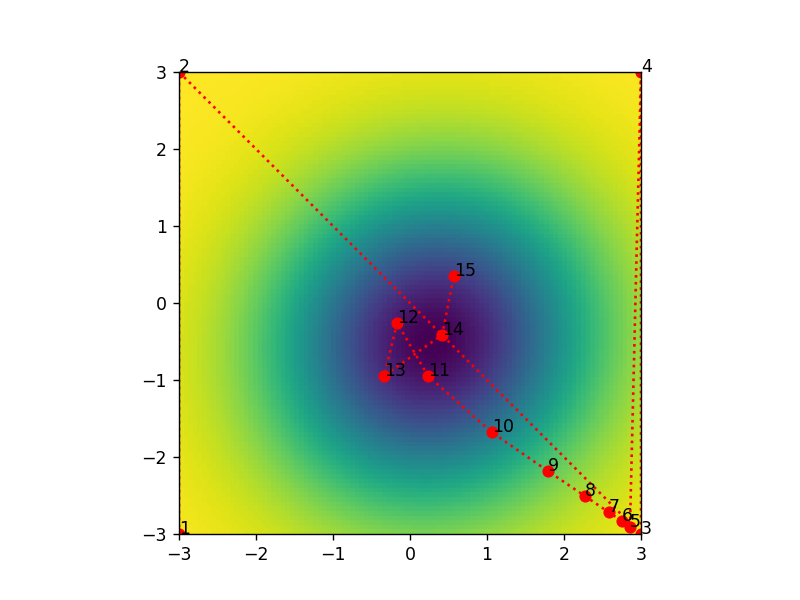

<IPython.core.display.Javascript object>


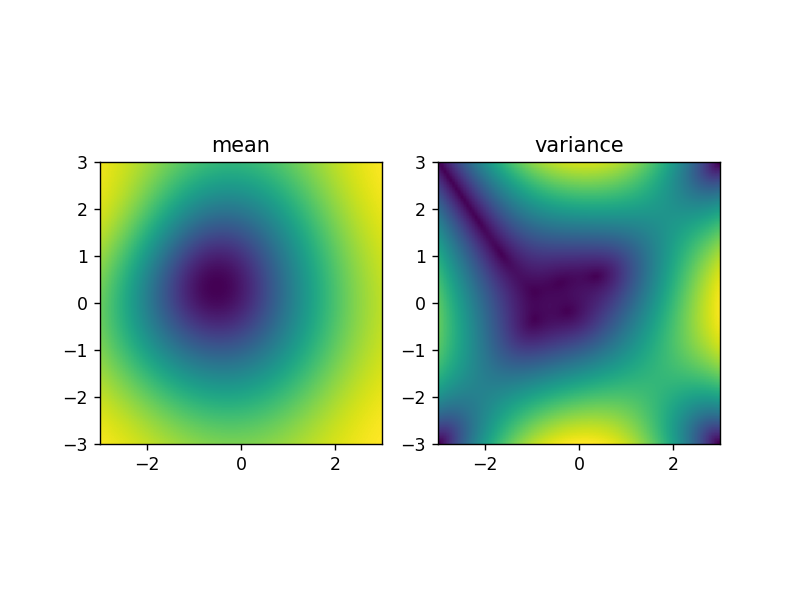

<IPython.core.display.Javascript object>


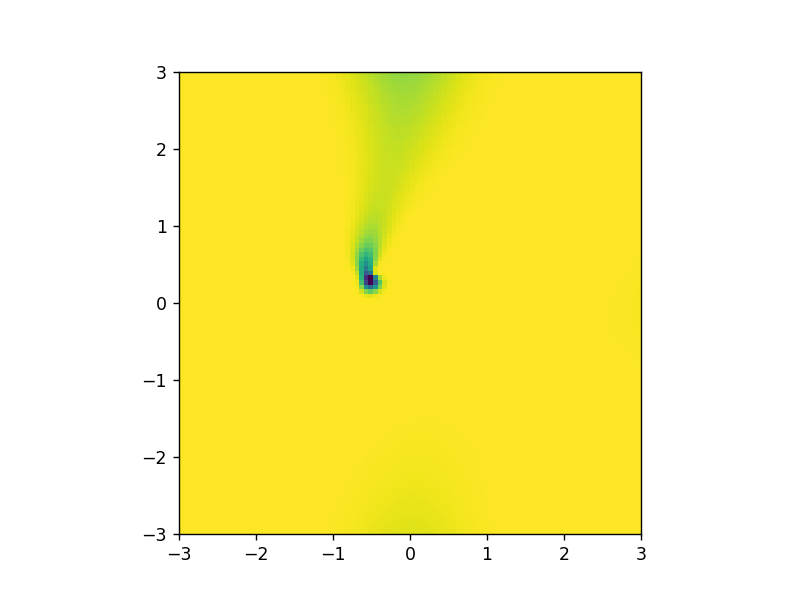

In [3]:
# Define function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
normal = multivariate_normal(mean=[0.3,-0.5], cov=[[2,.1],[.1,2]])
f= lambda x: -normal.pdf(x)
N = 100
x = np.linspace(-3,3,N)
x = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1)
Xinit = np.array([[-3,-3],[-3,3],[3,-3],[3,3]])

#GPyOpt
import GPyOpt
bounds2d = [{'name': 'x', 'type': 'continuous', 'domain': (-3,3)},
            {'name': 'y', 'type': 'continuous', 'domain': (-3,3)}]

bo = GPyOpt.methods.BayesianOptimization(f, domain=bounds2d, X=Xinit, acquisition_type='EI',exact_feval=True)
bo.run_optimization(max_iter = 11)

#Plotting
y=f(x.T).reshape(N,N).T
plt.figure('Optimization progress')
plt.imshow(y,cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.plot(bo.X[:,0],bo.X[:,1],'ro:')
for i,xx in enumerate(bo.X):
    plt.text(xx[0],xx[1],'%i'%(i+1))
plt.figure('Approximated function')
plt.subplot(1,2,1)
plt.title('mean')
plt.imshow(bo.model.predict(x.T)[0].reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.subplot(1,2,2)
plt.title('variance')
plt.imshow(bo.model.predict(x.T)[1].reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
#plt.suptitle('Approximated function')
plt.figure('Acquisition function')
plt.imshow(bo.acquisition.acquisition_function(x.T).reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);

# GPy extended tips
## Adding a prior on GP kernel parameters in GPyOpt

- For example to improve instability problem of hyper-parameter determination

### Define kernel

Matérn 5/2 with $\Gamma$ distribution prior on lengthscale and variance
$\Gamma$ parametrized by scale and $\text{rate}=\text{shape}^{-1}$
<code>
    import GPy
    k52 = GPy.kern.Matern52(input_dim=2, variance=1, lengthscale=50)
    k52.lengthscale.set_prior(GPy.priors.Gamma.from_EV(100, 1))
    k52.variance.set_prior(GPy.priors.Gamma.from_EV(1.,1.))
</code>

### Use it in the Bayesian optimization call:

<code>
    bopt = GPyOpt.methods.BayesianOptimization(sf, kernel=k, domain=bounds2d)
</code>

# Kernels can be added
Here an example with an extra noise kernel (White kernel):
<code>
    k_noise = GPy.kern.White(input_dim=2)
    kernel = k52+k_noise
</code>

# Kernels can also be multiplied
- Useful if one desire different lenghtscales on different inputs, here we also use the active_dims keyword

For example:
<code>
    k1 = GPy.kern.RBF(input_dim=1, active_dims=[0])
    k2 =  GPy.kern.RBF(input_dim=1, active_dims=[1])
    kernel = k1 * k2
</code>
From this you will effectively get separate variance and lengthscale parameters for the two dimensions.